In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

import editdistance
import glob
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

In [2]:
import flexs
from flexs import baselines
import flexs.utils.sequence_utils as s_utils

In [3]:
palette = {
    'AdaLead': 'royalblue',
    'DynaPPO': 'gold',
    'CbAS': 'green',
    'DbAS': 'lightgreen',
    'Random baseline': 'gray',
    'Evo_BO' :'red',
    'CMAES': 'purple',
    'WF-a0.0': 'darkblue'
}

In [31]:
def get_medians(pattern):
    '''Returns median true score in each csv matching `pattern`.'''
    medians = []
    for fname in glob.glob(pattern):
        with open(fname) as f:
            # Skip metadata in header
            next(f)
            df = pd.read_csv(f)
        medians.append(df['true_score'].median())
    
    return medians 

def get_means(pattern):
    '''Returns median true score in each csv matching `pattern`.'''
    means = []
    for fname in glob.glob(pattern):
        with open(fname) as f:
            # Skip metadata in header
            next(f)
            df = pd.read_csv(f)
        means.append(df['true_score'].mean())
    
    return means 

def get_maxes(pattern):
    '''Returns maximum true score in each csv matching `pattern`.'''
    maxes = []
    for fname in glob.glob(pattern):
        with open(fname) as f:
            # Skip metadata in header
            next(f)
            df = pd.read_csv(f)
        
        if df['true_score'].max() < 0.9:
            print(fname)
        
        maxes.append(df['true_score'].max())
    
    return maxes

## Figure 1A

## Figure 2A

../../paper_data_9_30/figure2a/cmaes/PAX3_G48R_R1_start2_cnn
../../paper_data_9_30/figure2a/cmaes/PAX3_G48R_R1_start1_cnn
../../paper_data_9_30/figure2a/cmaes/PAX3_G48R_R1_start4_cnn
../../paper_data_9_30/figure2a/cmaes/POU3F4_REF_R1_start1_cnn
../../paper_data_9_30/figure2a/cmaes/POU3F4_REF_R1_start0_cnn
../../paper_data_9_30/figure2a/cmaes/POU3F4_REF_R1_start2_cnn
../../paper_data_9_30/figure2a/cmaes/POU3F4_REF_R1_start3_cnn
../../paper_data_9_30/figure2a/cmaes/POU3F4_REF_R1_start11_cnn
../../paper_data_9_30/figure2a/cmaes/PAX3_G48R_R1_start12_cnn
../../paper_data_9_30/figure2a/cmaes/POU3F4_REF_R1_start6_cnn
../../paper_data_9_30/figure2a/cmaes/POU3F4_REF_R1_start4_cnn


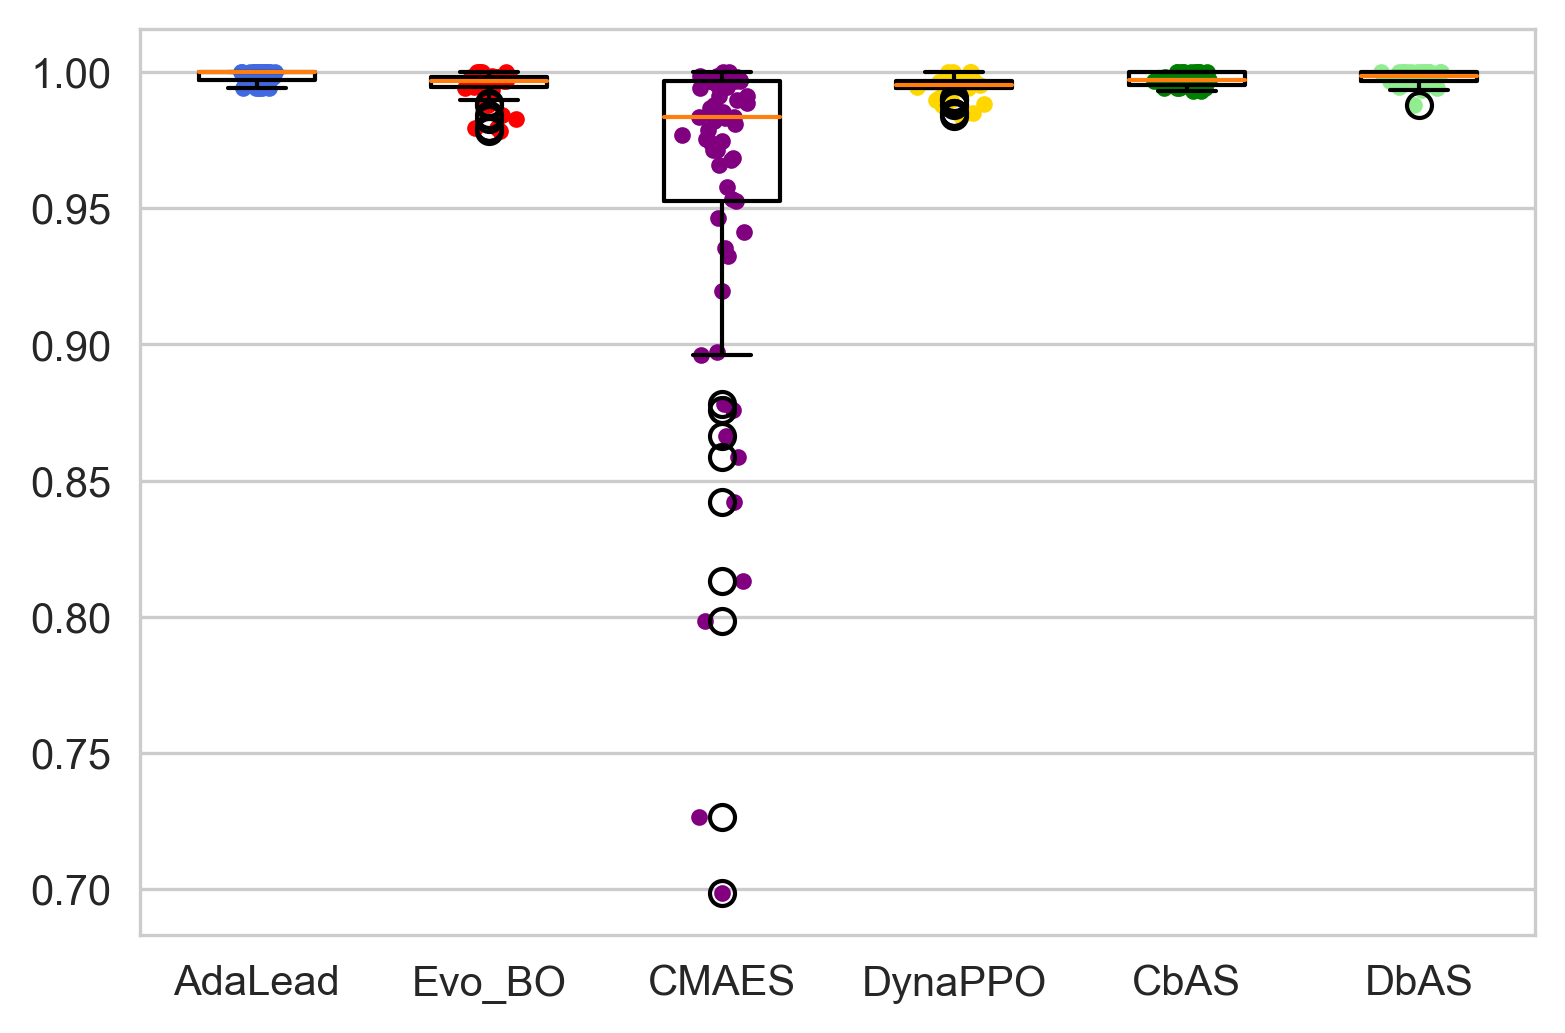

In [80]:
def jitter(x, size):
    return x + .05 * np.random.randn(size)

adalead_res = get_maxes('../../paper_data_9_30/figure2a/adalead/[!P]*R1*_cnn')
bo_res = get_maxes('../../paper_data_9_30/figure2a/bo/[!P]*R1*_cnn')
cmaes_res = get_maxes('../../paper_data_9_30/figure2a/cmaes/*R1*_cnn')
dynappo_res = get_maxes('../../paper_data_9_30/figure2a/dynappo/[!P]*R1*_cnn')
cbas_res = get_maxes('../../paper_data_9_30/figure2a/cbas/[!P]*R1*_cnn')
dbas_res = get_maxes('../../paper_data_9_30/figure2a/dbas/[!P]*R1*_cnn')

data = [adalead_res, bo_res, cmaes_res, dynappo_res, cbas_res, dbas_res]
names = ['AdaLead', 'Evo_BO', 'CMAES', 'DynaPPO', 'CbAS', 'DbAS']

plt.figure(dpi=300)
sns.set_style('whitegrid')
plt.grid(b=None, axis='x')
plt.boxplot(data, labels=names)
for i, (name, d) in enumerate(zip(names, data)):
    plt.scatter(jitter(i + 1, len(d)), d, c=palette[name], marker='.')
plt.show()

## Figure 2B

In [118]:
df = pd.read_csv('../../L14RNA1+2runs_old.csv')
df = df[df['model_type'] != 'Null']
df

,Unnamed: 0,batch,cum_max_fitness,explorer_type,landscape_id,max_fitness,model_type,start_id
0,0,1,0.418980,AdaLead,B2L14RNA1+2,0.448309,AM(ss=0),startRNAL14_0
1,0,2,0.519419,AdaLead,B2L14RNA1+2,0.555778,AM(ss=0),startRNAL14_0
2,0,3,0.519419,AdaLead,B2L14RNA1+2,0.536656,AM(ss=0),startRNAL14_0
3,0,4,0.849918,AdaLead,B2L14RNA1+2,0.909412,AM(ss=0),startRNAL14_0
4,0,5,0.849918,AdaLead,B2L14RNA1+2,0.838903,AM(ss=0),startRNAL14_0
...,...,...,...,...,...,...,...,...
2151,0,7,0.712747,CMAES,B2L14RNA1+2,0.738473,Ensemble,startRNAL14_4
2152,0,8,0.840287,CMAES,B2L14RNA1+2,0.899107,Ensemble,startRNAL14_4
2153,0,9,0.840287,CMAES,B2L14RNA1+2,0.653784,Ensemble,startRNAL14_4
2154,0,10,0.840287,CMAES,B2L14RNA1+2,0.838910,Ensemble,startRNAL14_4


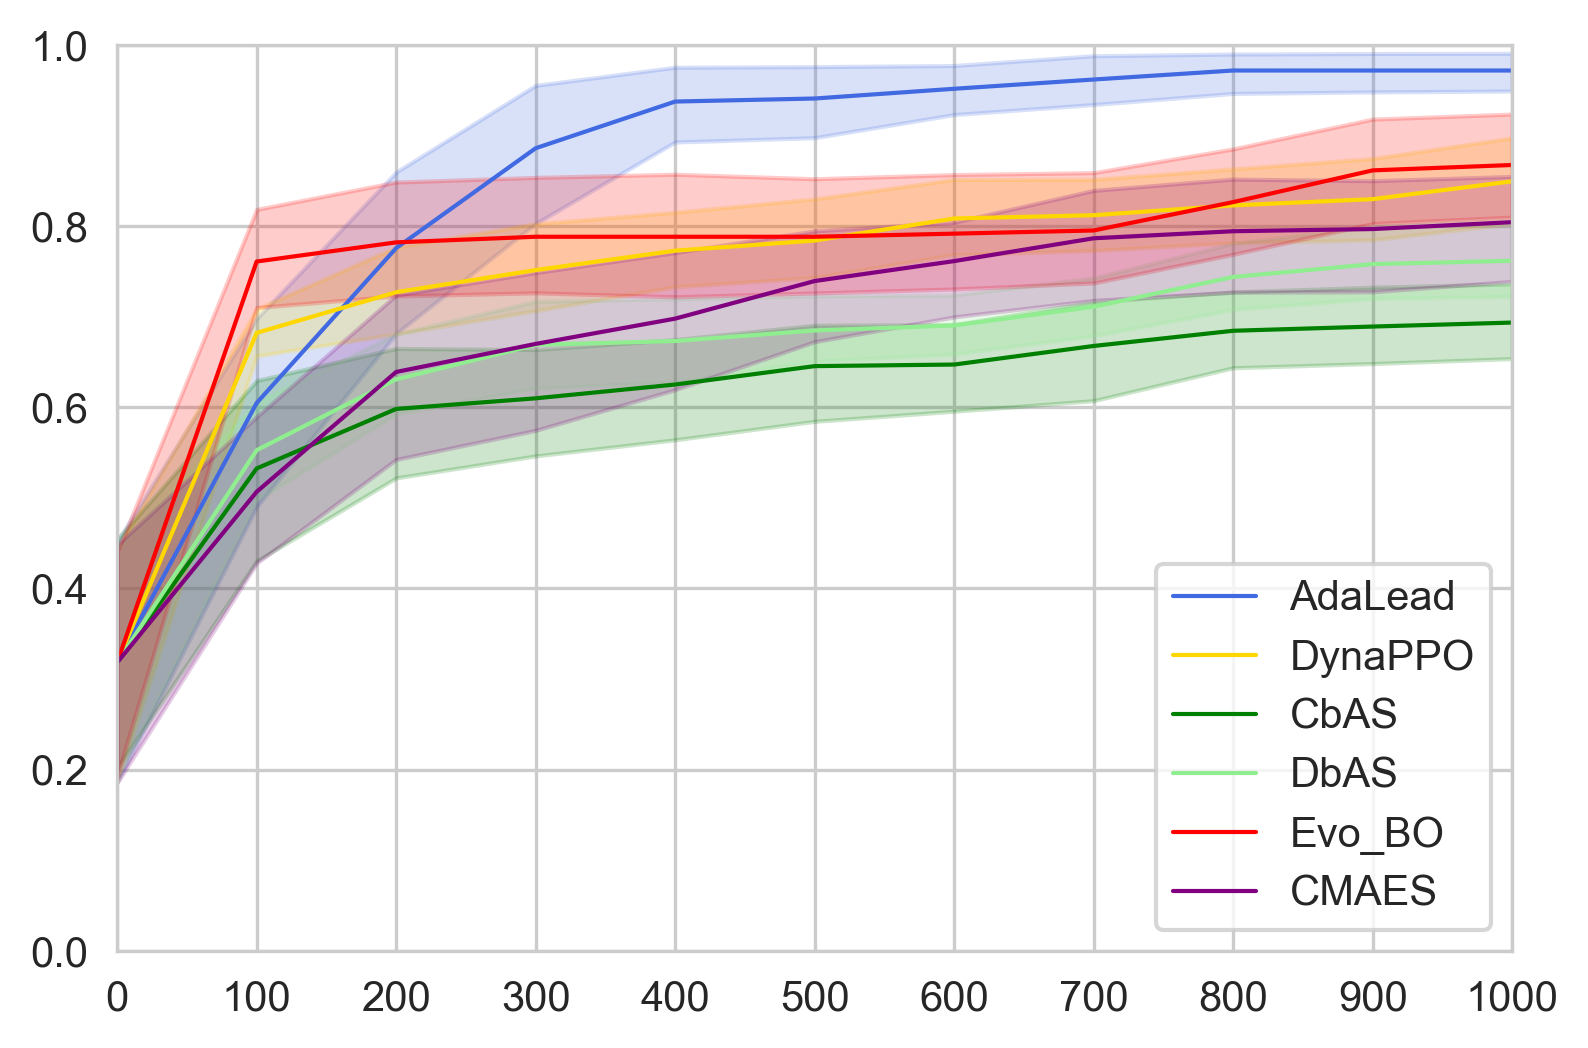

In [172]:
def cumulative_max_per_round(sequences):
    num_rounds = sequences['round'].max() + 1
    max_per_round = [sequences['true_score'][sequences['round'] == r].max()
                     for r in range(num_rounds)]
    return np.maximum.accumulate(max_per_round)

def compute_scores(run_dir):
    measurements = []
    scores = []
    for fname in glob.glob(f'{run_dir}/L14_RNA1+2_start*_ss1.0'):
        # Skip metadata in header
        with open(fname) as f:
            next(f)
            df = pd.read_csv(f)

        max_per_round = cumulative_max_per_round(df)
        scores.extend(max_per_round)
        measurements.extend(range(len(max_per_round)))
    
    return list(measurements), list(0.96 * np.array(scores))

names_and_dirs = {
    'AdaLead': '../../paper_data_9_30/table1/adalead',
    'DynaPPO': '../../paper_data_9_30/table1/dynappo',
    'CbAS': '../../paper_data_9_30/table1/cbas',
    'DbAS': '../../paper_data_9_30/table1/dbas',
    'Evo_BO': '../../paper_data_9_30/table1/bo',
    'CMAES': '../../paper_data_9_30/table1/cmaes',
}

plt.figure(dpi=300)
sns.set_style('whitegrid')
for name, run_dir in names_and_dirs.items():
    new_x, new_y = compute_scores(run_dir)
    
    x = []
    y = []
    for start in ['startRNAL14_0', 'startRNAL14_1', 'startRNAL14_2', 'startRNAL14_3', 'startRNAL14_4']:
        for batch in range(1, 12):
            select_df = (df['explorer_type'] == name) & (df['model_type'] == 'AM(ss=1)') & (df['start_id'] == start) & (df['batch'] == batch)
            x.append(df['batch'][select_df].item() - 1)
            y.append(df['cum_max_fitness'][select_df].item())
            
    sns.lineplot(x + new_x, y + new_y, label=name, color=palette[name], linewidth=1)
plt.xticks(range(11), range(0, 10001, 100))
plt.xlim(0, 10)
plt.ylim(0, 1)
plt.legend()
plt.show()

In [149]:
df['cum_max_fitness'][(df['explorer_type'] == 'AdaLead') &
                      (df['model_type'] == 'AM(ss=1)') &
                      (df['start_id'] == 'startRNAL14_0') &
                      (df['batch'] == 1)]

231    0.41898
Name: cum_max_fitness, dtype: float64

## Figure 2C

In [47]:
names_and_dirs = {
    'AdaLead': '../../paper_data_9_30/table1/adalead',
    'DynaPPO': '../../paper_data_9_30/table1/dynappo',
    'CbAS': '../../paper_data_9_30/table1/cbas',
    'DbAS': '../../paper_data_9_30/table1/dbas',
    'Evo_BO': '../../paper_data_9_30/table1/bo',
    'CMAES': '../../paper_data_9_30/table1/cmaes',
}
protein_names_and_dirs = {
    'AdaLead': '../../rosetta_cnn/adalead**',
    'DynaPPO': '../../rosetta_cnn/dynappo**',
    'CbAS': '../../rosetta_cnn/cbas**',
    'DbAS': '../../rosetta_cnn/dbas**',
    'Evo_BO': '../../rosetta_cnn/bo**',
    'CMAES': '../../rosetta_cnn/cmaes**'
}

plt.figure(dpi=300)
sns.set_style('whitegrid')

data = {
    'landscape': [],
    'algo': [],
    'maxes': [],
    'medians': [],
    'means': []
}
for i, landscape in enumerate(['C21_L100_RNA1+3', 'L14_RNA1+2', 'L14_RNA1']):
    for name, run_dir in names_and_dirs.items():
        for m in get_maxes(f'{run_dir}/{landscape}*ss*'):
            data['landscape'].append(landscape)
            data['algo'].append(name)
            data['maxes'].append(m)
        for m in get_medians(f'{run_dir}/{landscape}*ss*'):
            data['medians'].append(m)
        for m in get_means(f'{run_dir}/{landscape}*ss*'):
            data['means'].append(m)
for name, run_name in protein_names_and_dirs.items():
    for fname in glob.glob(run_name):
        with open(fname) as f:
            # Skip metadata in header
            df = pd.read_csv(f, skiprows=1)  
            data['landscape'].append('Rosetta')
            data['algo'].append(name)
            data['maxes'].append(df['true_score'].max())
            data['medians'].append(df['true_score'].median())  

_RNA1+3_start0_ss0.5
../../paper_data_9_30/table1/cbas/C21_L100_RNA1+3_start1_ss1.0
../../paper_data_9_30/table1/cbas/C21_L100_RNA1+3_start4_ss1.0
../../paper_data_9_30/table1/cbas/C21_L100_RNA1+3_start1_ss0.5
../../paper_data_9_30/table1/cbas/C21_L100_RNA1+3_start0_ss1.0
../../paper_data_9_30/table1/cbas/C21_L100_RNA1+3_start2_ss1.0
../../paper_data_9_30/table1/cbas/C21_L100_RNA1+3_start3_ss0.5
../../paper_data_9_30/table1/dbas/C21_L100_RNA1+3_start4_ss0.9
../../paper_data_9_30/table1/dbas/C21_L100_RNA1+3_start4_ss0.0
../../paper_data_9_30/table1/dbas/C21_L100_RNA1+3_start0_ss0.9
../../paper_data_9_30/table1/dbas/C21_L100_RNA1+3_start0_ss0.0
../../paper_data_9_30/table1/dbas/C21_L100_RNA1+3_start2_ss0.0
../../paper_data_9_30/table1/dbas/C21_L100_RNA1+3_start2_ss0.9
../../paper_data_9_30/table1/dbas/C21_L100_RNA1+3_start3_ss0.9
../../paper_data_9_30/table1/dbas/C21_L100_RNA1+3_start3_ss0.0
../../paper_data_9_30/table1/dbas/C21_L100_RNA1+3_start1_ss0.0
../../paper_data_9_30/table1/dbas/

<Figure size 1800x1200 with 0 Axes>

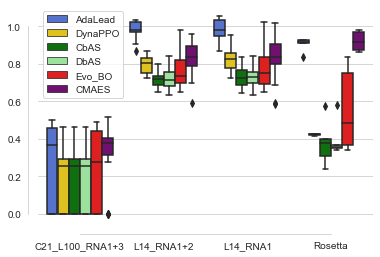

In [49]:
sns.boxplot(x='landscape', y='maxes', hue='algo', palette=palette, data=data)
sns.despine(offset=10, trim=True)

plt.legend()
plt.show()

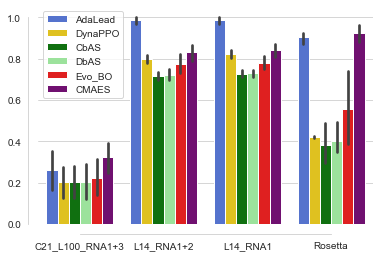

In [52]:
sns.barplot(x='landscape', y='maxes', hue='algo', palette=palette, data=data)
sns.despine(offset=10, trim=True)

plt.legend()
plt.show()

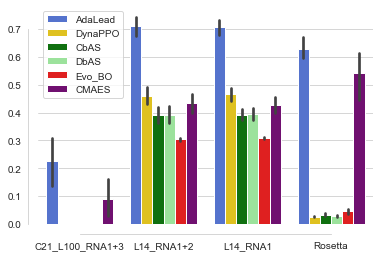

In [51]:
sns.barplot(x='landscape', y='medians', hue='algo', palette=palette, data=data)
sns.despine(offset=10, trim=True)

plt.legend()
plt.show()

[0.0, 0.0, 0.4541417142694495, 0.3498469181663433, 0.21329663833142354, 0.3090788772261565, 0.0, 0.0, 0.24824869527301655, 0.35656912823596243, 0.0, 0.0, 0.23591783337076283, 0.3599243053473937, 0.3904138107591232, 0.0, 0.2725091153101586, 0.4880798705880932, 0.37945202585576276, 0.0, 0.0, 0.0, 0.0006996257221133792, 0.0006996257221133792, 0.0003840589092808916, 0.0003840589092808916, 0.0, 0.0, 0.000442955641023305, 0.000442955641023305, 0.0, 0.0, 0.0003840589092808916, 0.0006996257221133792, 0.000442955641023305, 0.0, 0.000442955641023305, 0.0006996257221133792, 0.0003840589092808916, 0.0, 0.0, 0.0, 0.0004701823722780127, 0.0004701823722780127, 0.0002581061892846355, 0.0002581061892846355, 0.0, 0.0, 0.0002976876457331192, 0.0002976876457331192, 0.0, 0.0, 0.0002581061892846355, 0.0004701823722780127, 0.0002976876457331192, 0.0, 0.0002976876457331192, 0.0004701823722780127, 0.0002581061892846355, 0.0, 0.0, 0.0, 0.0004701823722780127, 0.0004701823722780127, 0.0002581061892846355, 0.00025

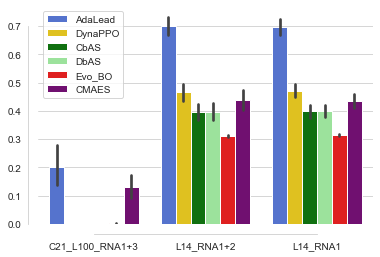

In [36]:
print(data['means'])
sns.barplot(x='landscape', y='means', hue='algo', palette=palette, data=data)
sns.despine(offset=10, trim=True)

plt.legend()
plt.show()

## Figure 2D

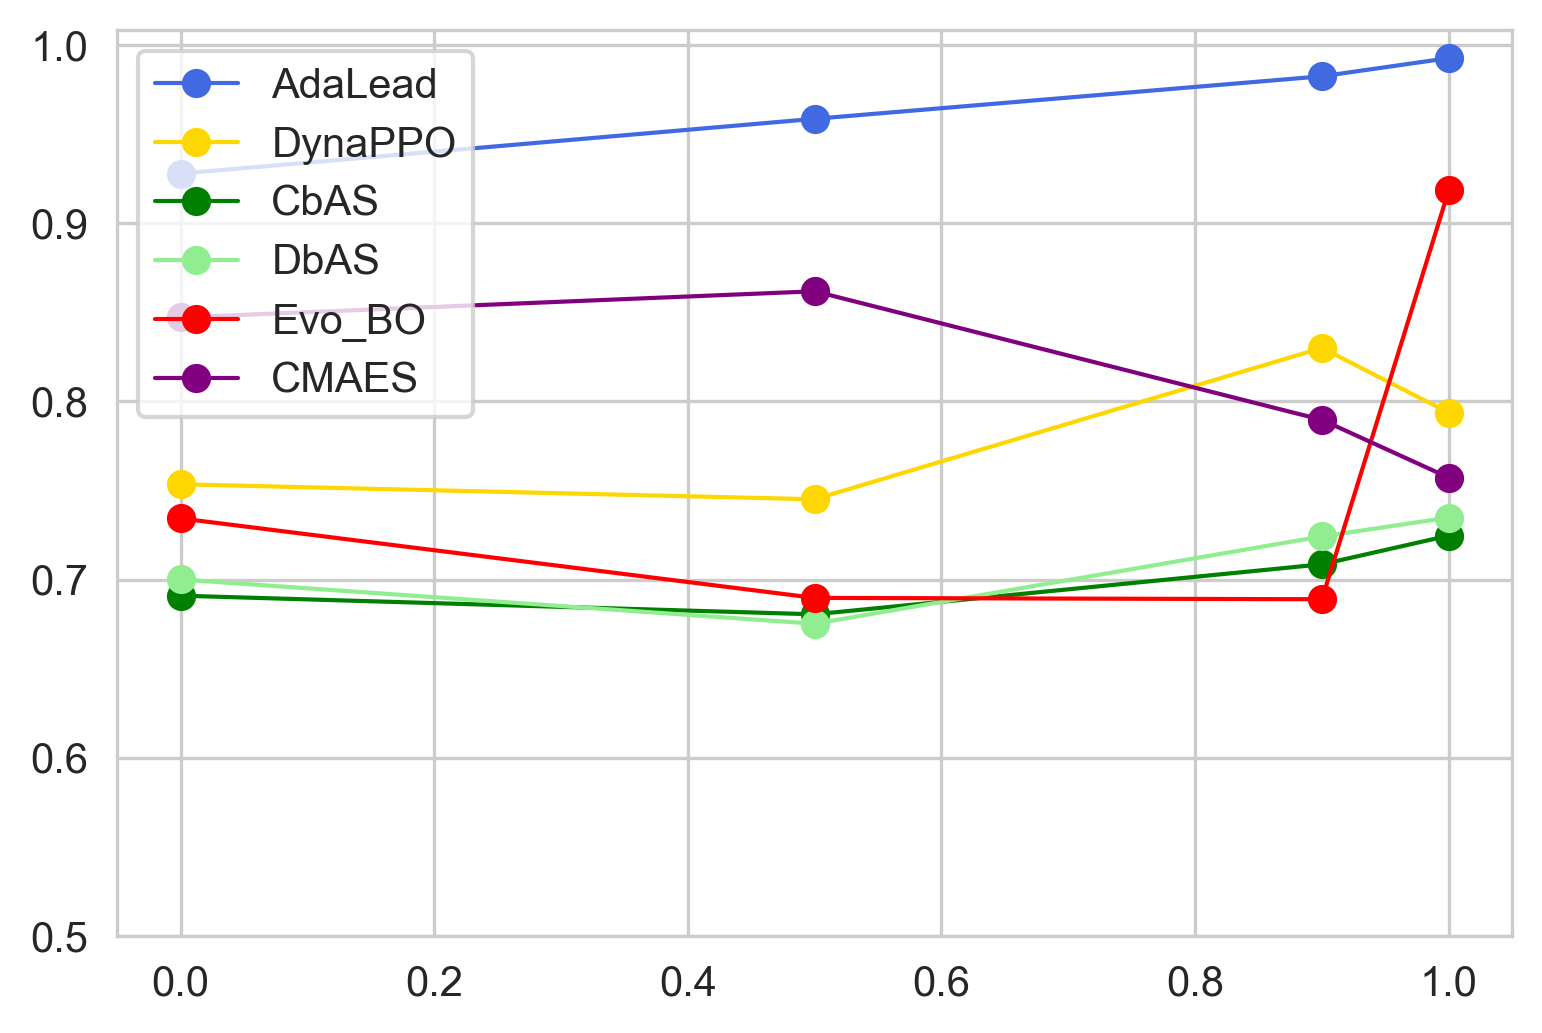

In [78]:
names_and_dirs = {
    'AdaLead': '../../paper_data_9_30/table1/adalead',
    'DynaPPO': '../../paper_data_9_30/table1/dynappo',
    'CbAS': '../../paper_data_9_30/table1/cbas',
    'DbAS': '../../paper_data_9_30/table1/dbas',
    'Evo_BO': '../../paper_data_9_30/table1/bo',
    'CMAES': '../../paper_data_9_30/table1/cmaes',
}

plt.figure(dpi=300)
sns.set_style('whitegrid')

for name, run_dir in names_and_dirs.items():
    ss_mean_maxes = [0.98 * np.mean(get_maxes(f'{run_dir}/L14_RNA1+2_start*_ss{ss}'))
                     for ss in ['0.0', '0.5', '0.9', '1.0']]
    
    plt.plot([0, 0.5, 0.9, 1], ss_mean_maxes, '-o', label=name, color=palette[name], linewidth=1)

plt.ylim(0.5)
plt.legend()
plt.show()

## Rosetta Plot

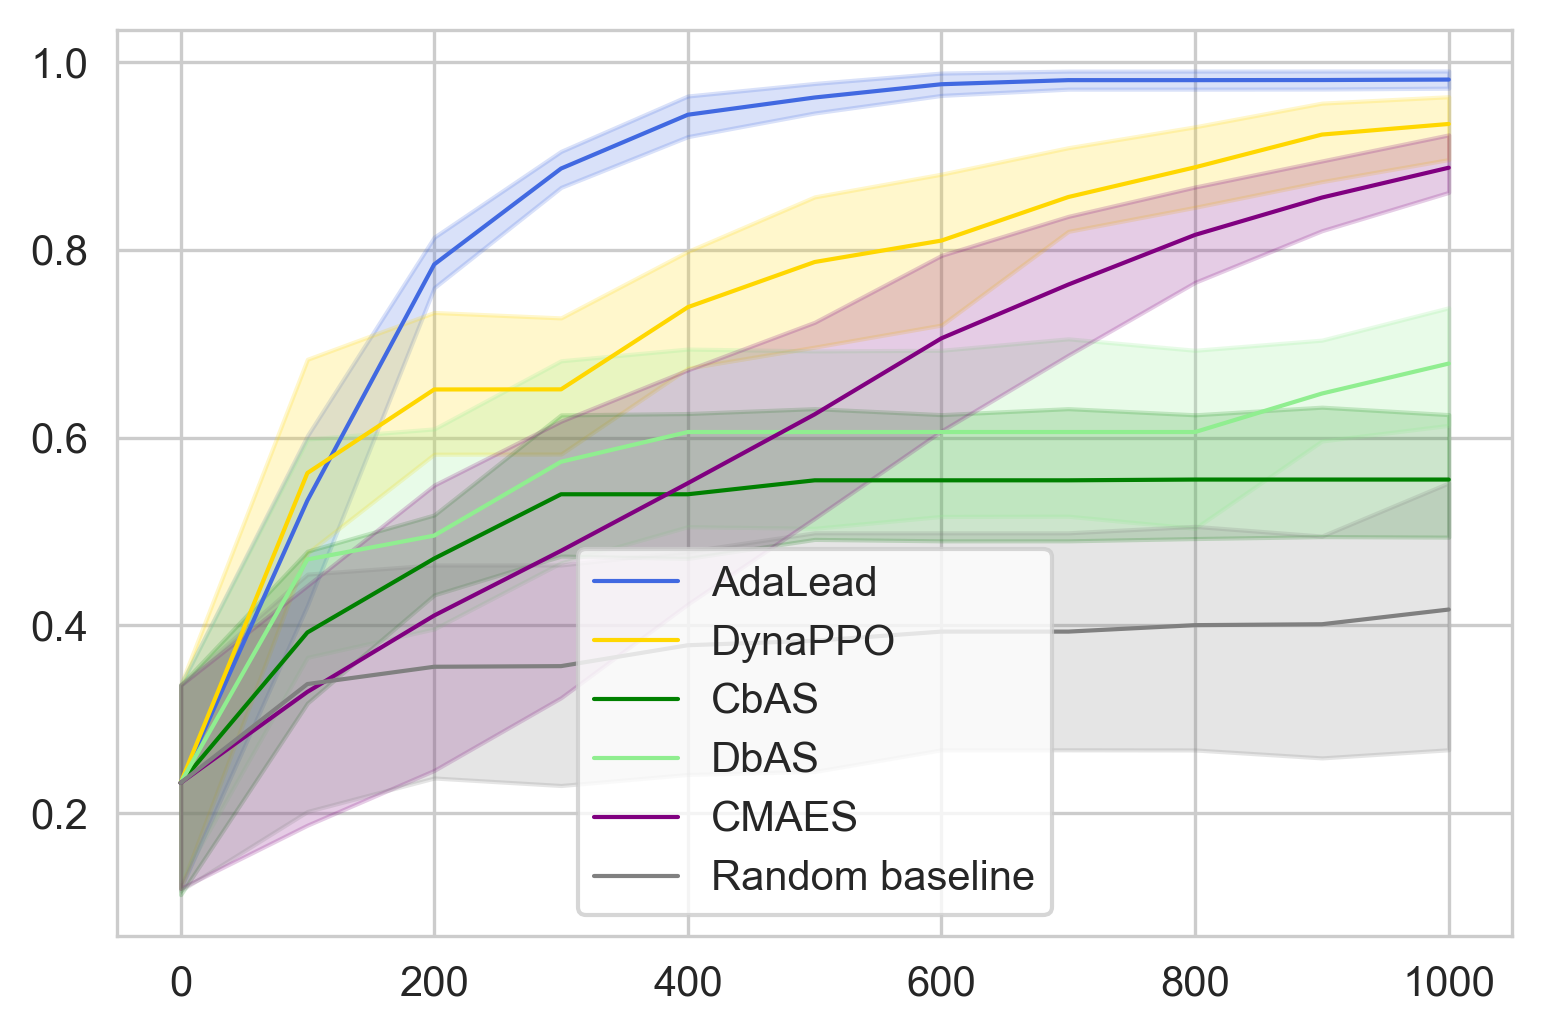

In [47]:
def cumulative_max_per_round(sequences):
    num_rounds = sequences['round'].max() + 1
    max_per_round = [sequences['true_score'][sequences['round'] == r].max()
                     for r in range(num_rounds)]
    return np.maximum.accumulate(max_per_round)

def compute_scores(run_dir):
    measurements = []
    scores = []
    for fname in glob.glob(f'{run_dir}/*'):
        # Skip metadata in header
        with open(fname) as f:
            next(f)
            df = pd.read_csv(f)

        max_per_round = cumulative_max_per_round(df)
        scores.extend(max_per_round)
        measurements.extend(np.arange(len(max_per_round)) * 100)
    
    return measurements, scores

names_and_dirs = {
    'AdaLead': '../cloud/runs/3msi/adalead',
    'DynaPPO': '../cloud/runs/3msi/dynappo',
    'CbAS': '../cloud/runs/3msi/cbas',
    'DbAS': '../cloud/runs/3msi/dbas',
    'CMAES': '../cloud/runs/3msi/cmaes',
    'Evo_BO': '../cloud/runs/3msi/bo',
    'Random baseline': '../cloud/runs/3msi/random',
}

plt.figure(dpi=300)
sns.set_style('whitegrid')
for name, run_dir in names_and_dirs.items():
    sns.lineplot(*compute_scores(run_dir), label=name, color=palette[name], linewidth=1)
plt.legend()
plt.show()